In [3]:
from pathlib import Path

import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd

## Checks

**Problem**: Probability map is cut off at the bottom, but the binary map is fine.

Facts:

    - The combined.tif and also the binary map are not cut at the bottom.
    - The intermediate probability map (before clipping) but already compressed and casted to uint8 also has the cut. This means the issue is not due to clipping.
    - The cut happens at different places for different versions of the map.

**Hypothesis**: The cut depends on the transformed data values and maybe on the compression.
- Check 1: check that the no data value are mantained in the binary map first. -> OK
- Check 2: make probability map without clipping, compression or casting to uint8 (only changing no-data value). -> OK
- Check 3: make probability map without clipping or compression (but with casting to uint8) -> OK, no cut, this mean the problem is in compression.
- Check 4: check that no data values are mantained between raw predictions and probability map without compression. -> OK
- Check 5: make probability map without compression, but with casting to uint8 and clipping. Check that it's not cut. -> OK, I could use this map already (it's 14GB though)
- Check 6: check that final probability and binary maps have the same missing values. -> OK

**Solution**: Make clipped probability map without compression (final size: 14GB).

### Check 1: combined.tif and binary intermediate mask should preserve the no-data values ->**OK**

In [7]:
map_version = 4
preds_dir = Path(f"../data/predictions/nigeria-cropharvest-full-country-2020/v{map_version}")
base_filename = 'combined'
tif_path = preds_dir / f'{base_filename}.tif'

In [8]:
with rasterio.open(tif_path) as map:
    meta = map.meta
    bounds = map.bounds
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842)}

In [9]:
with rasterio.open(tif_path) as map:
    data = map.read(1)
data

array([[0.41090655, 0.64520943, 0.6577012 , ..., 0.08016538, 0.0814566 ,
        0.08545445],
       [0.25899586, 0.35356057, 0.38515893, ..., 0.08041115, 0.07872102,
        0.08439897],
       [0.1724457 , 0.24476607, 0.28418174, ..., 0.08397247, 0.07885724,
        0.08129588],
       ...,
       [       nan,        nan,        nan, ..., 0.00918175, 0.01175091,
        0.488538  ],
       [       nan,        nan,        nan, ..., 0.00550667, 0.00620588,
        0.47301495],
       [       nan,        nan,        nan, ..., 0.01732424, 0.04461752,
        0.40613696]], dtype=float32)

In [11]:
data.nbytes / 1e9

58.666748664

In [12]:
nan_mask = np.isnan(data)

In [15]:
nan_mask.nbytes / 1e9

14.666687166

In [17]:
nan_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])


Load binary intermediate mask

In [22]:
tif_path = preds_dir / f'{base_filename}_binary_uint8_lzw.tif'

In [23]:
with rasterio.open(tif_path) as map:
    meta = map.meta
    data = map.read(1)
meta, data

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 134346,
  'height': 109171,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 14.047584918475842)},
 array([[  0,   1,   1, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0]], dtype=uint8))

In [25]:
nodata_value = meta['nodata']
nodata_value

255.0

In [26]:
arr = np.ma.array(data, mask=(data == int(nodata_value)))
arr

masked_array(
  data=[[0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [--, --, --, ..., 0, 0, 0],
        [--, --, --, ..., 0, 0, 0],
        [--, --, --, ..., 0, 0, 0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=999999,
  dtype=uint8)

In [30]:
arr.mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [31]:
nan_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [33]:
binary_nans_comparison = nan_mask == arr.mask

In [36]:
all(binary_nans_comparison.flatten())

True

The missing values match!

### Check 2: Make probability map without clipping, compression or casting to uint8 -> **OK, map doesn't have the cut**

In [2]:
map_version = 4
preds_dir = Path(f"../data/predictions/nigeria-cropharvest-full-country-2020/v{map_version}")
base_filename = 'combined'
tif_path = preds_dir / f'{base_filename}.tif'

In [3]:
with rasterio.open(tif_path) as map:
    meta = map.meta
    bounds = map.bounds
    data = map.read(1)
meta, data

({'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': nan,
  'width': 134346,
  'height': 109171,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 14.047584918475842)},
 array([[0.41090655, 0.64520943, 0.6577012 , ..., 0.08016538, 0.0814566 ,
         0.08545445],
        [0.25899586, 0.35356057, 0.38515893, ..., 0.08041115, 0.07872102,
         0.08439897],
        [0.1724457 , 0.24476607, 0.28418174, ..., 0.08397247, 0.07885724,
         0.08129588],
        ...,
        [       nan,        nan,        nan, ..., 0.00918175, 0.01175091,
         0.488538  ],
        [       nan,        nan,        nan, ..., 0.00550667, 0.00620588,
         0.47301495],
        [       nan,        nan,        nan, ..., 0.01732424, 0.04461752,
         0.40613696]], dtype=float32))

In [4]:
nan_mask = np.isnan(data)

In [5]:
NODATA_VALUE = 255

In [6]:
data[nan_mask] = NODATA_VALUE

In [7]:
data

array([[4.1090655e-01, 6.4520943e-01, 6.5770119e-01, ..., 8.0165379e-02,
        8.1456602e-02, 8.5454449e-02],
       [2.5899586e-01, 3.5356057e-01, 3.8515893e-01, ..., 8.0411151e-02,
        7.8721024e-02, 8.4398970e-02],
       [1.7244570e-01, 2.4476607e-01, 2.8418174e-01, ..., 8.3972469e-02,
        7.8857243e-02, 8.1295878e-02],
       ...,
       [2.5500000e+02, 2.5500000e+02, 2.5500000e+02, ..., 9.1817519e-03,
        1.1750906e-02, 4.8853800e-01],
       [2.5500000e+02, 2.5500000e+02, 2.5500000e+02, ..., 5.5066673e-03,
        6.2058782e-03, 4.7301495e-01],
       [2.5500000e+02, 2.5500000e+02, 2.5500000e+02, ..., 1.7324237e-02,
        4.4617515e-02, 4.0613696e-01]], dtype=float32)

In [8]:
meta.update({'nodata': NODATA_VALUE})

In [11]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 255,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842)}

In [12]:
dtype = meta['dtype']
dtype

'float32'

In [14]:
target_path = preds_dir / f'{base_filename}_probability_{dtype}.tif'
target_path

PosixPath('../data/predictions/nigeria-cropharvest-full-country-2020/v4/combined_probability_float32.tif')

In [15]:
with rasterio.open(target_path, 'w', **meta) as dst:
    dst.write(data, 1)


Here we're only updating the no-data value to 255. Map size remains the same (55GB). When visualizing in QGIS, map doesn't have the cut!

### Check 3: Make probability map without clipping or compression (but with casting to uint8) -> **OK, map doesn't have the cut**

In [2]:
NODATA_VALUE = 255
DTYPE = rasterio.uint8

In [3]:
map_version = 4
preds_dir = Path(f"../data/predictions/nigeria-cropharvest-full-country-2020/v{map_version}")
base_filename = 'combined'
tif_path = preds_dir / f'{base_filename}.tif'

In [4]:
with rasterio.open(tif_path) as map:
    meta = map.meta
    bounds = map.bounds
    data = map.read(1)
meta, data

({'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': nan,
  'width': 134346,
  'height': 109171,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 14.047584918475842)},
 array([[0.41090655, 0.64520943, 0.6577012 , ..., 0.08016538, 0.0814566 ,
         0.08545445],
        [0.25899586, 0.35356057, 0.38515893, ..., 0.08041115, 0.07872102,
         0.08439897],
        [0.1724457 , 0.24476607, 0.28418174, ..., 0.08397247, 0.07885724,
         0.08129588],
        ...,
        [       nan,        nan,        nan, ..., 0.00918175, 0.01175091,
         0.488538  ],
        [       nan,        nan,        nan, ..., 0.00550667, 0.00620588,
         0.47301495],
        [       nan,        nan,        nan, ..., 0.01732424, 0.04461752,
         0.40613696]], dtype=float32))

In [5]:
nan_mask = np.isnan(data)

In [6]:
data = data * 100
data

array([[41.090656  , 64.52094   , 65.77012   , ...,  8.016538  ,
         8.14566   ,  8.5454445 ],
       [25.899586  , 35.356056  , 38.515892  , ...,  8.041115  ,
         7.8721023 ,  8.439897  ],
       [17.24457   , 24.476606  , 28.418175  , ...,  8.397247  ,
         7.885724  ,  8.129588  ],
       ...,
       [        nan,         nan,         nan, ...,  0.91817516,
         1.1750906 , 48.853798  ],
       [        nan,         nan,         nan, ...,  0.55066675,
         0.6205878 , 47.301495  ],
       [        nan,         nan,         nan, ...,  1.7324237 ,
         4.4617515 , 40.613697  ]], dtype=float32)

In [7]:
data = data.astype(DTYPE)
data

array([[41, 64, 65, ...,  8,  8,  8],
       [25, 35, 38, ...,  8,  7,  8],
       [17, 24, 28, ...,  8,  7,  8],
       ...,
       [ 0,  0,  0, ...,  0,  1, 48],
       [ 0,  0,  0, ...,  0,  0, 47],
       [ 0,  0,  0, ...,  1,  4, 40]], dtype=uint8)

In [8]:
nan_mask2 = np.isnan(data)

In [9]:
nan_mask2.sum() # 0 means no NaNs and that when doing data.astype(DTYPE) the NaNs were converted to 0s

0

In [10]:
data[nan_mask] = NODATA_VALUE

In [11]:
data

array([[ 41,  64,  65, ...,   8,   8,   8],
       [ 25,  35,  38, ...,   8,   7,   8],
       [ 17,  24,  28, ...,   8,   7,   8],
       ...,
       [255, 255, 255, ...,   0,   1,  48],
       [255, 255, 255, ...,   0,   0,  47],
       [255, 255, 255, ...,   1,   4,  40]], dtype=uint8)

In [12]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842)}

In [13]:
meta.update({'nodata': NODATA_VALUE, 'dtype': DTYPE})
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842)}

In [14]:
dtype = meta['dtype']
dtype

'uint8'

In [15]:
target_path = preds_dir / f'{base_filename}_probability_{dtype}.tif'
target_path

PosixPath('../data/predictions/nigeria-cropharvest-full-country-2020/v4/combined_probability_uint8.tif')

In [16]:
with rasterio.open(target_path, 'w', **meta) as dst:
    dst.write(data, 1)

### Check 4: check that no data values are mantained between raw predictions and probability map without compression. -> **OK**

In [4]:
NODATA_VALUE = 255
DTYPE = rasterio.uint8

In [5]:
map_version = 4
preds_dir = Path(f"../data/predictions/nigeria-cropharvest-full-country-2020/v{map_version}")
base_filename = 'combined'
tif_path = preds_dir / f'{base_filename}_probability_uint8.tif'

In [6]:
with rasterio.open(tif_path) as map:
    meta = map.meta
    bounds = map.bounds
    data = map.read(1)
meta, data

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 134346,
  'height': 109171,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 14.047584918475842)},
 array([[ 41,  64,  65, ...,   8,   8,   8],
        [ 25,  35,  38, ...,   8,   7,   8],
        [ 17,  24,  28, ...,   8,   7,   8],
        ...,
        [255, 255, 255, ...,   0,   1,  48],
        [255, 255, 255, ...,   0,   0,  47],
        [255, 255, 255, ...,   1,   4,  40]], dtype=uint8))

In [10]:
nodata_value = meta['nodata']
nodata_value

255.0

In [11]:
arr = np.ma.array(data, mask=(data == int(nodata_value)))
arr

masked_array(
  data=[[41, 64, 65, ..., 8, 8, 8],
        [25, 35, 38, ..., 8, 7, 8],
        [17, 24, 28, ..., 8, 7, 8],
        ...,
        [--, --, --, ..., 0, 1, 48],
        [--, --, --, ..., 0, 0, 47],
        [--, --, --, ..., 1, 4, 40]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=999999,
  dtype=uint8)

In [12]:
arr.mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

Load tif with original predictions

In [20]:
tif_path = preds_dir / f'{base_filename}.tif'
tif_path

PosixPath('../data/predictions/nigeria-cropharvest-full-country-2020/v4/combined.tif')

In [19]:
with rasterio.open(tif_path) as map:
    meta = map.meta
    bounds = map.bounds
    data = map.read(1)
meta, data

({'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': nan,
  'width': 134346,
  'height': 109171,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 14.047584918475842)},
 array([[0.41090655, 0.64520943, 0.6577012 , ..., 0.08016538, 0.0814566 ,
         0.08545445],
        [0.25899586, 0.35356057, 0.38515893, ..., 0.08041115, 0.07872102,
         0.08439897],
        [0.1724457 , 0.24476607, 0.28418174, ..., 0.08397247, 0.07885724,
         0.08129588],
        ...,
        [       nan,        nan,        nan, ..., 0.00918175, 0.01175091,
         0.488538  ],
        [       nan,        nan,        nan, ..., 0.00550667, 0.00620588,
         0.47301495],
        [       nan,        nan,        nan, ..., 0.01732424, 0.04461752,
         0.40613696]], dtype=float32))

In [21]:
nan_mask = np.isnan(data)

In [22]:
nan_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [23]:
binary_nans_comparison = nan_mask == arr.mask

In [24]:
all(binary_nans_comparison.flatten())

True

### Check 5: Make probability map without compression but with clipping -> **OK, clipped probability map finally looks good. Issue was compression**

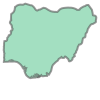

In [4]:
borders_file = gpd.read_file(Path('../assets/nigeria_borders.shp'))
borders_geometry = borders_file.geometry[0]
borders_geometry

In [5]:
[geom for geom in borders_geometry.geoms]

In [6]:
NODATA_VALUE = 255
DTYPE = rasterio.uint8

In [7]:
map_version = 4
preds_dir = Path(f"../data/predictions/nigeria-cropharvest-full-country-2020/v{map_version}")
base_filename = 'combined'
tif_path = preds_dir / f'{base_filename}_probability_uint8.tif'
tif_path

PosixPath('../data/predictions/nigeria-cropharvest-full-country-2020/v4/combined_probability_uint8.tif')

In [8]:
with rasterio.open(tif_path) as src:
    meta = src.meta
    data, transform = mask(src, borders_geometry, crop=True, all_touched=True, nodata=NODATA_VALUE)
meta, data, transform

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/rasterio/features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 134346,
  'height': 109171,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 14.047584918475842)},
 array([[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8),
 Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 13.872862595714636))

In [9]:
nodata_value = meta['nodata']
nodata_value

255.0

In [10]:
arr = np.ma.array(data, mask=(data == int(nodata_value)))
arr

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],
  fill_value=999999,
  dtype=uint8)

In [14]:
arr.mask.sum() / arr.mask.size

0.3477281886136159

In [15]:
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842)}

In [17]:
data = np.squeeze(data) # seems to save space in the final tif
data

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [18]:
meta.update({
        "height": data.shape[0],
        "width": data.shape[1],
        "transform": transform
        })
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 132866,
 'height': 106817,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 13.872862595714636)}

In [19]:
final_tif_path = Path(str(tif_path).replace('.tif', '_clipped.tif'))
final_tif_path

PosixPath('../data/predictions/nigeria-cropharvest-full-country-2020/v4/combined_probability_uint8_clipped.tif')

In [20]:
with rasterio.open(final_tif_path, "w", **meta) as dst:
        dst.write(data, 1)

### Check 6: check that final probability and binary maps have the same missing values. -> **OK**

In [ ]:
NODATA_VALUE = 255
DTYPE = rasterio.uint8

In [21]:
map_version = 4
preds_dir = Path(f"../data/predictions/nigeria-cropharvest-full-country-2020/v{map_version}")
base_filename = 'combined'
binary_map = preds_dir / f'{base_filename}_binary_uint8_lzw_clipped.tif'
prob_map = preds_dir / f'{base_filename}_probability_uint8_clipped.tif'

In [22]:
with rasterio.open(binary_map) as map:
    meta = map.meta
    data = map.read(1)
meta, data

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 132866,
  'height': 106817,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 13.872862595714636)},
 array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8))

In [23]:
nodata_value = meta['nodata']
nodata_value

255.0

In [24]:
arr1 = np.ma.array(data, mask=(data == int(nodata_value)))
arr1

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

In [25]:
arr1.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Load tif with probability map

In [26]:
with rasterio.open(prob_map) as map:
    meta = map.meta
    data = map.read(1)
meta, data

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 132866,
  'height': 106817,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 13.872862595714636)},
 array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8))

In [27]:
arr2 = np.ma.array(data, mask=(data == int(nodata_value)))
arr2

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

In [28]:
arr2.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [29]:
nodata_comparison = arr1.mask == arr2.mask

In [30]:
all(nodata_comparison.flatten())

True

: 